<h2 align=center>Generate Synthetic Images with DCGANs in Keras</h2>

In this project, we will work with Keras API with tensorflow 2.0 backend

The images that DCGAN model will generate in this project (gif) after every epoch. The input to DCGAN is just a vector of random noise (Gaussian Distributed Noise). 

Over time, the model is able to learn transformation from this simple Gaussian Distributed Noise to the distribution that we care about (images in the training set). Unlike other techniques such as AE, VAEs, here we are trying to sample from complex high sample distribution. Instead DCGANs samples from very simple distribution like Gaussian Nosie and learn from noise to distribution that we care about (images).

This transformation is done with the help of Neural Networks. In this project we are transforming gray scale images from Fashion MNIST dataset. Later we can do for color images (RGB) as well.

## Task 1: Project Overview and Import Libraries

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import plot_utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.1.0


## Task 2: Load and Preprocess the Data

In [2]:
#Fashion MNIST (generator and discriminator)

(x_train,y_train),(x_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()

# images pixels 0-255 and we need to standardize it else slower performance/ poor results

x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0


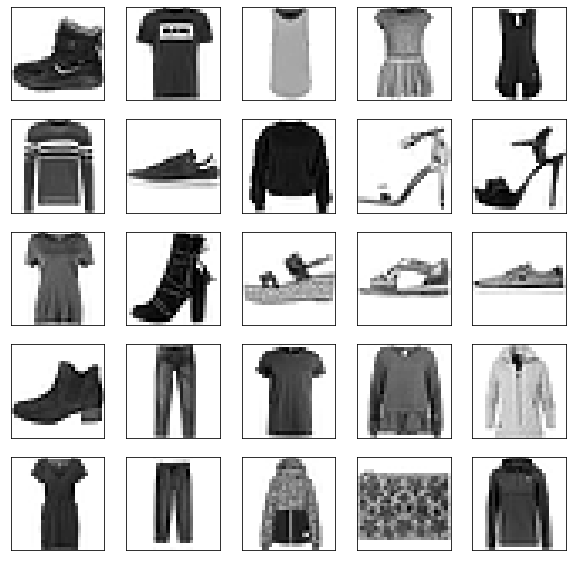

In [3]:
#visualize some inages 5 x 5 grid images

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary) # for gray scale
plt.show()

## Task 3: Create Batches of Training Data

In [4]:
# Creating batches and shuffling data as it can fit in any batch of tensors

batch_size = 32

dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)

# a buffer with 1000 elements and randomly sampling from this buffer and then replacing
# these elements with new elements

#combine elements into batches

dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)

#prefetch elements from dataset for batches of buffer 1

## Task 4: Build the Generator Network for DCGAN

![GAN](DCGAN.png)

**Generator** is an upsampling network with fractionally-strided convolutions

**Discriminator** is a convolutional network

Architecture guidelines for stable Deep Convolutional GANs:

- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers expect for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.

[Source](https://arxiv.org/pdf/1511.06434.pdf): Radford et al, "*Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks*", ICLR 2016

In [5]:
num_features = 100 # >30 (depending upon compute power available)keras.layer

#generator model to reach 28*28*1

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128,input_shape=[num_features]), #small DCGAN
    keras.layers.Reshape([7,7,128]),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2DTranspose(64,(5,5),(2,2),padding='same',activation='selu'), #selu activation and betetr for DCGANs
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1,(5,5),(2,2),padding='same',activation='tanh')
])

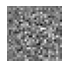

In [6]:
# vector of random noise without being trained

noise = tf.random.normal(shape=[1,num_features])

generated_image = generator(noise,training=False)

plot_utils.show(generated_image,1) #plot utils for plotting images rather than writing again and again


## Task 5: Build the Discriminator Network for DCGAN

In [7]:
#discriminator model using CNN

discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5,5),(2,2),padding='same',input_shape=[28,28,1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(128,(5,5),(2,2),padding='same'),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1,activation='sigmoid')
])

In [8]:
decision = discriminator(generated_image) #check discriminator on random noise image

print(decision)

tf.Tensor([[0.5006864]], shape=(1, 1), dtype=float32)


## Task 6: Compile the Deep Convolutional Generative Adversarial Network (DCGAN)

In [9]:
discriminator.compile(loss='binary_crossentropy',optimizer='rmsprop')

discriminator.trainable = False #to train generator and discriminator separately

gan = keras.models.Sequential([generator,discriminator])
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

## Task 7: Define Training Procedure

In [10]:
seed = tf.random.normal(shape=[batch_size,100]) # seed image

In [11]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [12]:
# for each iteration, we will train first discriminator and then generator. For discriminator
# we will sample mini batches for discriminator from training data. Then we obtain fake images 
# from random noise and in generator and then compare real images with discriminator
# We will pick gradient step for mini batches for fake and real images and update the discriminator

def train_dcgan(gan,dataset,batch_size, num_features, epochs=5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)): #iteration for each epoch with tqdm - distribution of every epoch
        print('Epochs {}/{}'.format(epoch+1, epochs))
        for X_batch in dataset: #iteration for batches in dataset
            #train generator a bit
            noise = tf.random.normal(shape=[batch_size,num_features])
            generated_images = generator(noise) #pass random noise to generated to get generated image (FAKE)
            
            X_fake_and_real = tf.concat([generated_images, X_batch],axis=0)
            #class labels specify
            y1 = tf.constant([[0.]]*batch_size +[[1.]]*batch_size)
            
            discriminator.trainable = True #train discriminator
            discriminator.train_on_batch(X_fake_and_real,y1)
            
            y2 = tf.constant([[1.]]*batch_size) #labels for discriminator
            
            discriminator.trainable = False #stop discriminator training
            
            gan.train_on_batch(noise,y2) #training GAN
        
        display.clear_output(wait=True) #don't want previous output there
        generate_and_save_images(generator, epoch+1,seed)
    
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)
        
            

## Task 8: Train DCGAN

In [13]:
x_train_dcgan = x_train.reshape(-1,28,28, 1)*2. -1.

In [14]:
#create batch from Fashion MNIST
batch_size = 32

dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(1000)
dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)

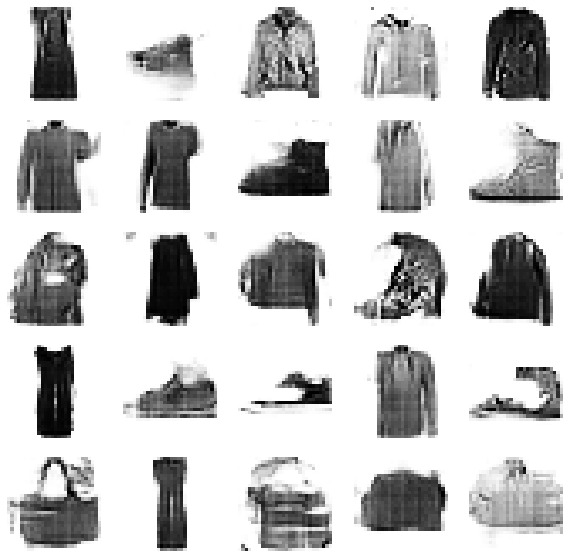

In [15]:
#Training dcgan

train_dcgan(gan,dataset,batch_size,num_features,epochs=10)

## Task 9: Generate Synthetic Images with DCGAN

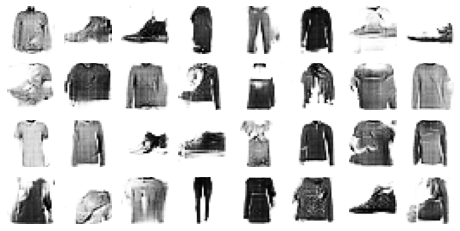

In [16]:
noise = tf.random.normal(shape=[batch_size,num_features])
generated_images = generator(noise)

plot_utils.show(generated_images,8) #8 is columns

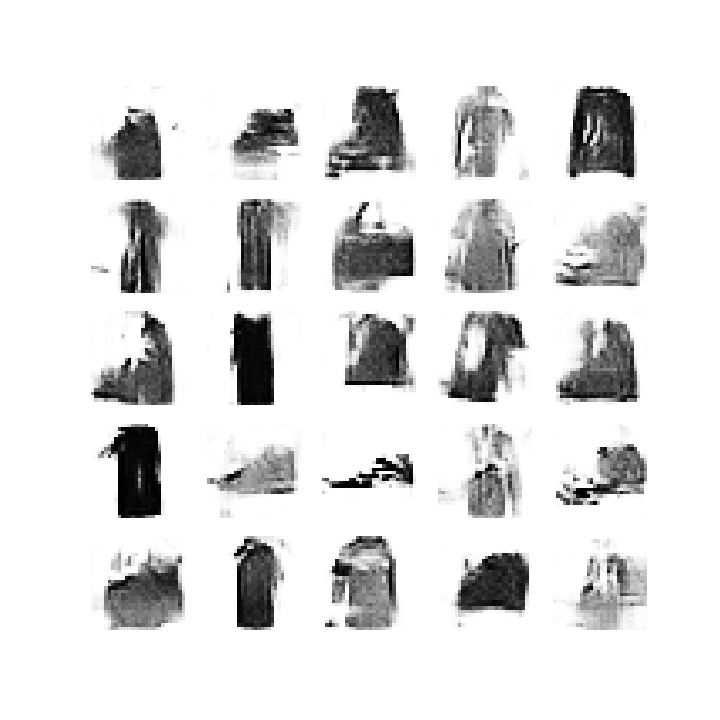

In [18]:
## Source: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif

import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
display.Image(filename=anim_file)